# 1. Data Processing

- Uploaded and extracted the GTSRB training dataset (43 labeled folders of .ppm images).
- Applied transforms: resized images to 32×32, converted to tensors, and normalized pixel values.
- Loaded the dataset using ImageFolder to structure images with correct class labels.
- Created a label mapping dictionary to associate class indices (0–42) with human-readable traffic sign names.
- Visualized the class distribution to identify imbalances in the training data

## 1.1 Load GTSRB Dataset


## 1.2 Resize Images

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
### Colab

data_dir = "GTSRB/Final_Training/Images"

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # resize all images to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## 1.3 Structure the Dataset

In [4]:
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


## 1.4 Human-Readable Label Mapping

In [6]:
class_labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## 1.5 Visualize Class Distribution with ImageFolder

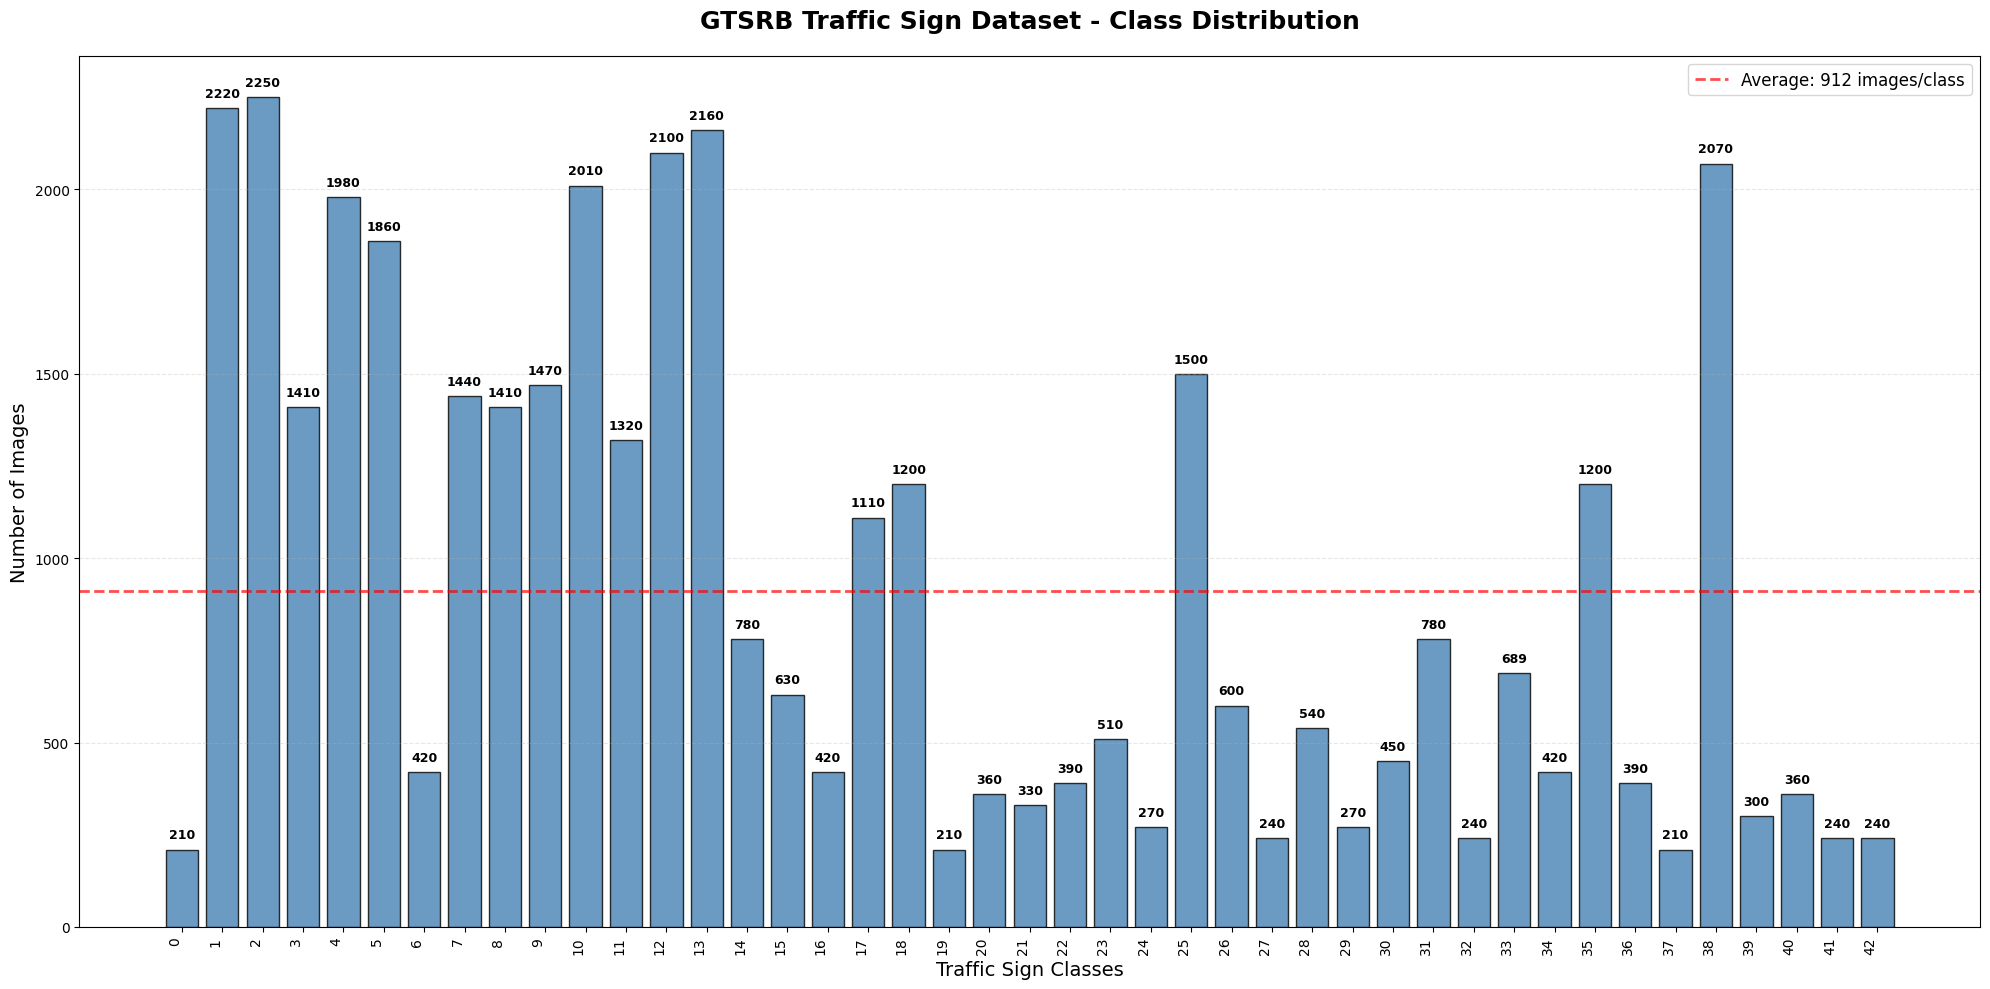

In [12]:
import os 
import numpy as np
import matplotlib.pyplot as plt

all_folders = os.listdir(data_dir)
class_folders = [f for f in all_folders if len(f) == 5 and f.isdigit()]
class_folders.sort()


# Count images in each folder
class_counts = []
class_numbers = []

for folder in class_folders:
    folder_path = os.path.join(data_dir, folder)
    files = os.listdir(folder_path)
    ppm_count = len([f for f in files if f.lower().endswith('.ppm')])
    
    class_counts.append(ppm_count)
    class_numbers.append(int(folder))  


# plot 
plt.figure(figsize=(20, 10))
bars = plt.bar(range(len(class_folders)), class_counts, 
               color="steelblue", edgecolor='black', alpha=0.8)
plt.title('GTSRB Traffic Sign Dataset - Class Distribution', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Traffic Sign Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(range(len(class_folders)), class_labels, 
           rotation=90, ha='right', fontsize=10)

# Add count labels on bars 
max_height = max(class_counts) if class_counts else 0
for i, (bar, count) in enumerate(zip(bars, class_counts)):
    if count > max_height * 0.03:  
        plt.text(bar.get_x() + bar.get_width()/2., count + max_height*0.01,
                f'{count}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add average line
if class_counts:
    avg_count = np.mean(class_counts)
    plt.axhline(y=avg_count, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Average: {avg_count:.0f} images/class')
    plt.legend(fontsize=12)

plt.tight_layout()
plt.show()



## 1.6 Display One Image from Each Class

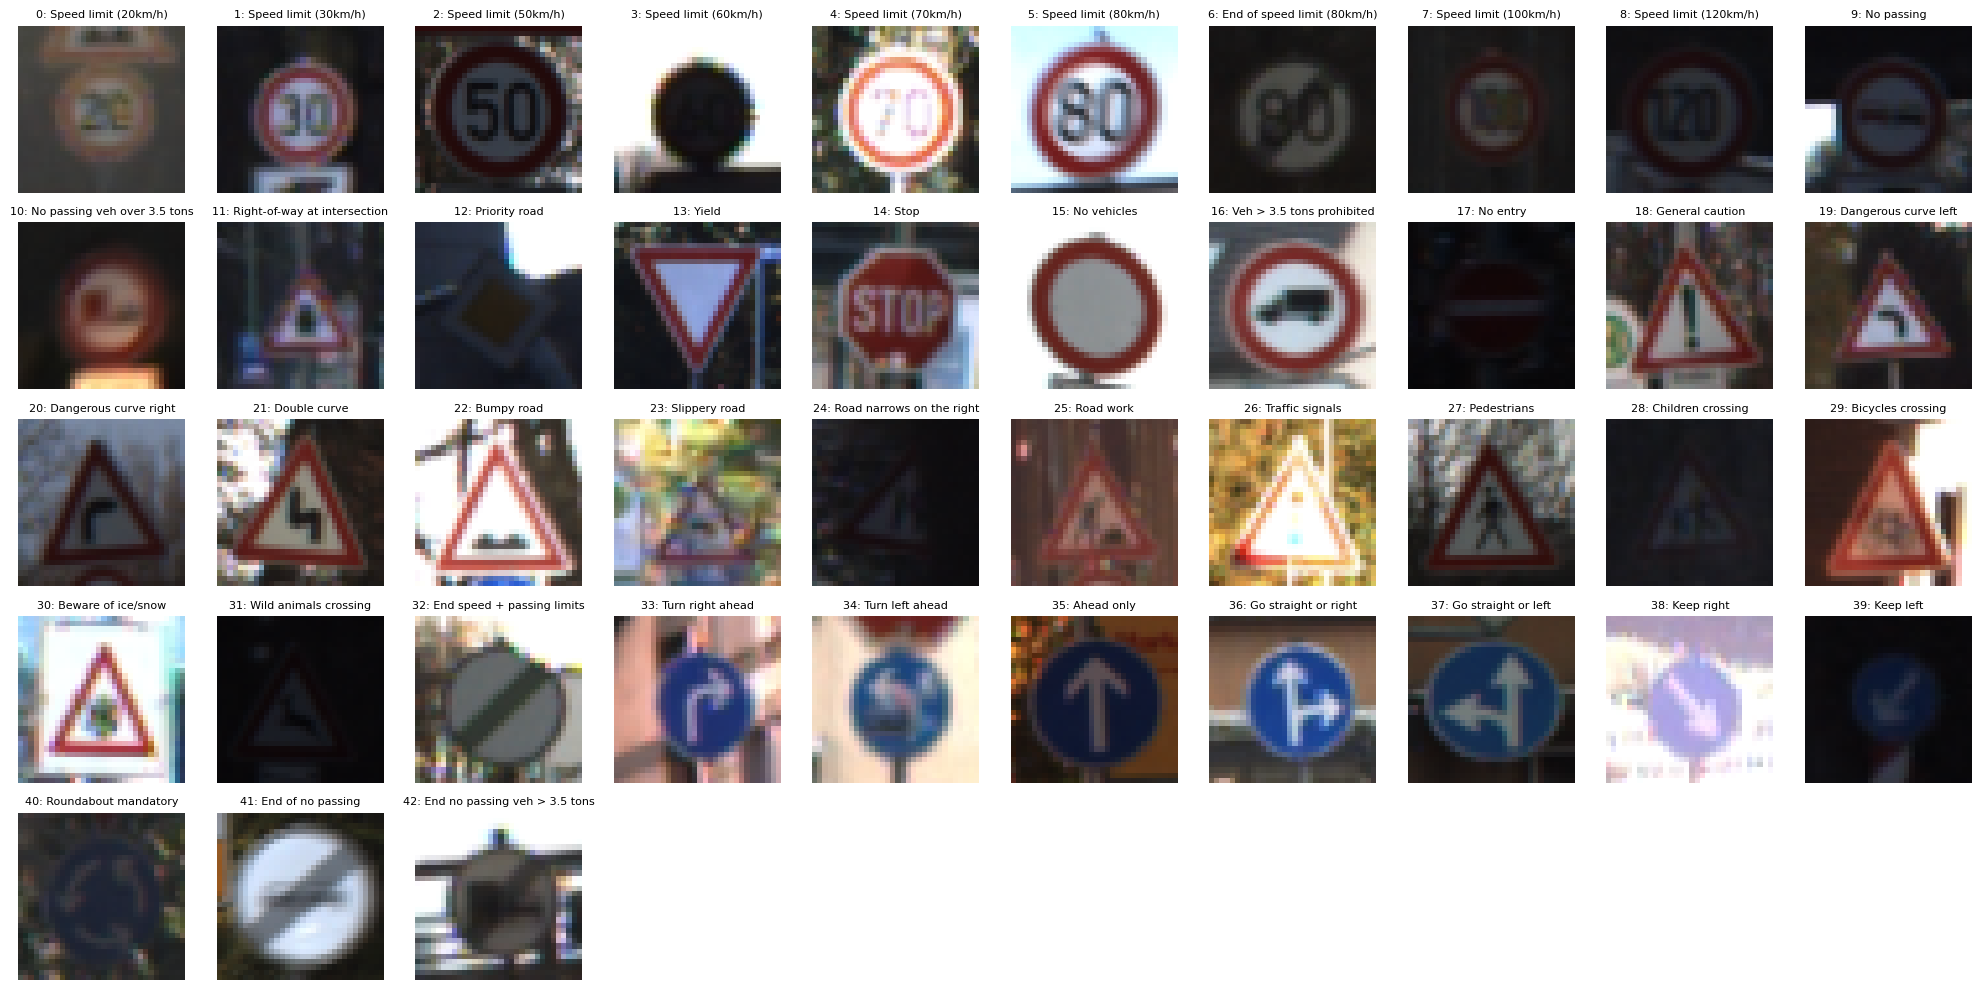

In [8]:
import random
import matplotlib.pyplot as plt
import math

def display_images_in_grid(dataset, class_labels, images_per_row=10):
    """
    Displays one random image from each class in a grid.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to sample from.
        class_labels (dict): A dictionary mapping class indices to human-readable labels.
        images_per_row (int): The number of images to display per row in the grid.
    """
    images_to_display = {}
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label not in images_to_display:
            images_to_display[label] = []
        images_to_display[label].append((image, label))

    # Collect one random image from each class
    selected_images = []
    sorted_classes = sorted(images_to_display.keys())
    for class_index in sorted_classes:
        class_images = images_to_display[class_index]
        random.shuffle(class_images)
        if class_images:
            selected_images.append(class_images[0])

    num_images = len(selected_images)
    num_rows = math.ceil(num_images / images_per_row)
    num_cols = images_per_row

    plt.figure(figsize=(2 * num_cols, 2 * num_rows)) # Adjust figure size as needed

    for i, (image_tensor, label) in enumerate(selected_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Convert tensor to numpy array and transpose dimensions for matplotlib
        image_np = image_tensor.permute(1, 2, 0).numpy()
        # Denormalize the image
        image_np = image_np * 0.5 + 0.5

        plt.imshow(image_np)
        plt.title(f"{label}: {class_labels[label]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display one random image from each class in a grid
display_images_in_grid(train_dataset, class_labels, images_per_row=10)

# 2. Dataset Manipulation

In [17]:
from torch.utils.data import random_split, DataLoader

# Step 1.1 — Define the sizes
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Step 1.2 — Randomly split dataset
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Step 1.3 — Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


# 3. Baseline Model

## Define the Baseline Model (2-layer CNN from Lab 3)
This is our baseline CNN that mimics a HOG+SVM pipeline:

In [13]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5)      # Input: 3×32×32 → 5×28×28
        self.pool = nn.MaxPool2d(2, 2)                   # → 5×14×14
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)     # → 10×10×10 → pool → 10×5×5
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 43)                     # 43 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Set up model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Train and Evaluate the Model

In [15]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Loss={running_loss:.3f}, Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

## Run the Training

In [18]:
train(model, train_loader, val_loader, epochs=10)

Epoch 1: Loss=1160.921, Train Acc=0.339, Val Acc=0.600
Epoch 2: Loss=295.558, Train Acc=0.810, Val Acc=0.887
Epoch 3: Loss=140.801, Train Acc=0.918, Val Acc=0.933
Epoch 4: Loss=93.017, Train Acc=0.945, Val Acc=0.933
Epoch 5: Loss=68.274, Train Acc=0.961, Val Acc=0.961
Epoch 6: Loss=53.918, Train Acc=0.970, Val Acc=0.954
Epoch 7: Loss=51.084, Train Acc=0.970, Val Acc=0.948
Epoch 8: Loss=40.413, Train Acc=0.977, Val Acc=0.969
Epoch 9: Loss=36.329, Train Acc=0.979, Val Acc=0.966
Epoch 10: Loss=29.478, Train Acc=0.983, Val Acc=0.970
